# Advanced Netflix Viewing History Analysis

This notebook reads and cleans your Netflix viewing history, parses titles into series/season/episode, adds temporal features, and runs multiple in‐depth analytical functions.

## 1. Setup & Title Parsing

In [1]:
import pandas as pd
import sys
from pathlib import Path

# 1. Read raw data
netflix_data = pd.read_csv('NetflixViewingHistory-Begum.csv', sep=';', header=1)

# 2. Parse date column
netflix_data.rename(columns={'Date':'Date'}, inplace=True)
netflix_data['Date'] = pd.to_datetime(netflix_data['Date'], format='%m/%d/%y')

# 3. Split Title into Series/Season/Episode
split_columns = netflix_data['Title'].str.extract(
    r'^(.*?)(?:: Season (\d+))?: (.*)$'
)
split_columns.columns = ['Series', 'Season', 'Episode']
split_columns['Series'].fillna(netflix_data['Title'], inplace=True)
split_columns['Season'].fillna('Movie', inplace=True)
split_columns['Episode'].fillna('Movie', inplace=True)
split_columns['Season'] = split_columns['Season'].astype('category')

# 4. Combine cleaned columns
netflix_data_cleaned = pd.concat(
    [netflix_data.drop(columns=['Title']), split_columns], axis=1
)

# Preview
netflix_data_cleaned.head()

/var/folders/h4/txnzvsxj0zd2cw00_l9z1rdc0000gn/T/ipykernel_87194/2758912191.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  split_columns['Series'].fillna(netflix_data['Title'], inplace=True)
/var/folders/h4/txnzvsxj0zd2cw00_l9z1rdc0000gn/T/ipykernel_87194/2758912191.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

,Date,Series,Season,Episode
0,2025-04-17,Kimler Geldi Kimler Geçti,Movie,1. Sezon: İlişki Durumu Karışık
1,2025-04-14,100 Humans,Movie,Acı ve Zevk
2,2025-04-14,100 Humans,Movie,Ön Yargılı mısınız?
3,2025-04-14,From Scratch,Movie,Mini Dizi: İlk Tatlar
4,2025-04-14,100 Humans,Movie,"Hadi, Biraz Cinsiyetlerden Konuşalım"


## 2. Add Temporal Features

In [2]:
# Add Year, Month, Day, Weekday, and Seasonal bins
df = netflix_data_cleaned.copy()
df['Year']    = df['Date'].dt.year
df['Month']   = df['Date'].dt.month
df['Day']     = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.day_name()
df['Season']  = pd.cut(
    df['Date'].dt.month,
    bins=[0,3,6,9,12],
    labels=['Winter','Spring','Summer','Fall']
)

# Preview temporal features
df[['Date','Year','Month','Day','Weekday','Season']].head()

,Date,Year,Month,Day,Weekday,Season
0,2025-04-17,2025,4,17,Thursday,Spring
1,2025-04-14,2025,4,14,Monday,Spring
2,2025-04-14,2025,4,14,Monday,Spring
3,2025-04-14,2025,4,14,Monday,Spring
4,2025-04-14,2025,4,14,Monday,Spring


## 3. Viewing Trends Over Time

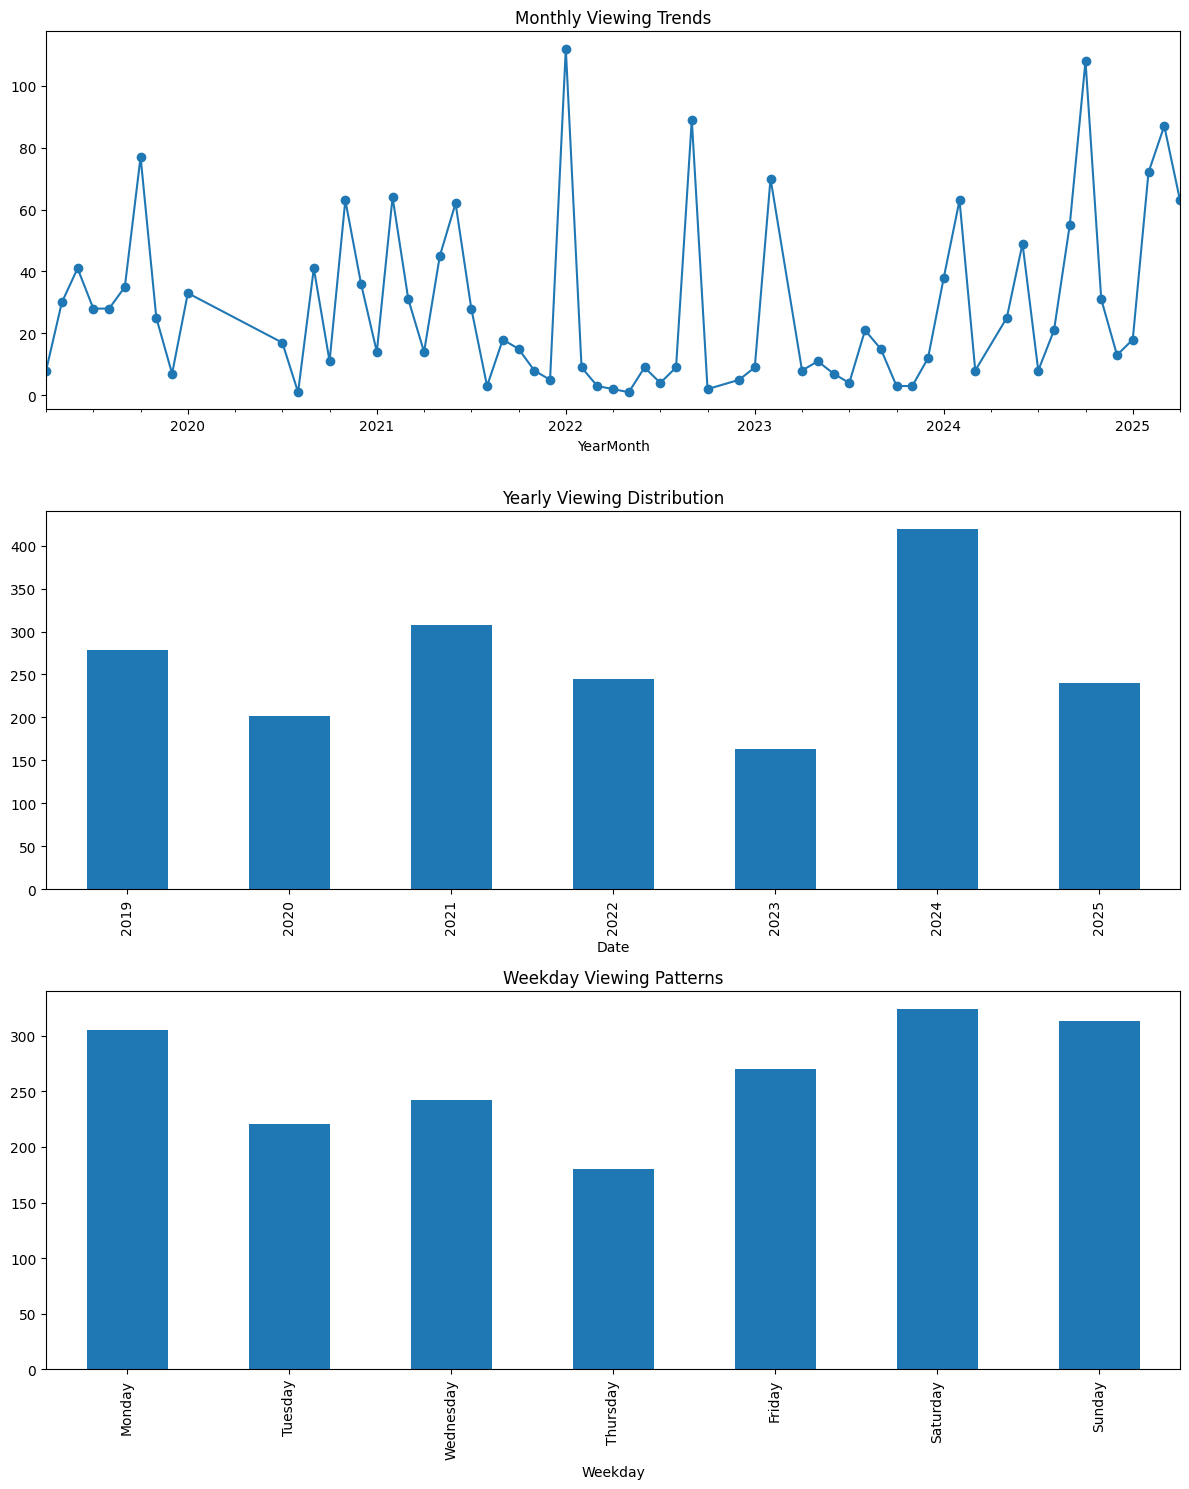

In [3]:
import matplotlib.pyplot as plt
from datetime import datetime

def analyze_viewing_trends(df):
    # Monthly, Yearly, Weekday counts
    df['YearMonth'] = df['Date'].dt.to_period('M')
    monthly_views = df.groupby('YearMonth').size()
    yearly_views  = df.groupby(df['Date'].dt.year).size()
    weekday_views = df.groupby(df['Weekday']).size()

    # Plot
    fig, axes = plt.subplots(3,1,figsize=(12,15))
    monthly_views.plot(ax=axes[0], title='Monthly Viewing Trends', marker='o')
    yearly_views.plot(ax=axes[1], kind='bar', title='Yearly Viewing Distribution')
    weekday_views.reindex(
        ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    ).plot(ax=axes[2], kind='bar', title='Weekday Viewing Patterns')
    plt.tight_layout()
    return monthly_views, yearly_views, weekday_views

monthly_views, yearly_views, weekday_views = analyze_viewing_trends(df)

## 4. Series Watching Patterns

/var/folders/h4/txnzvsxj0zd2cw00_l9z1rdc0000gn/T/ipykernel_87194/3414886144.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df_series.groupby(['Series','Season']):


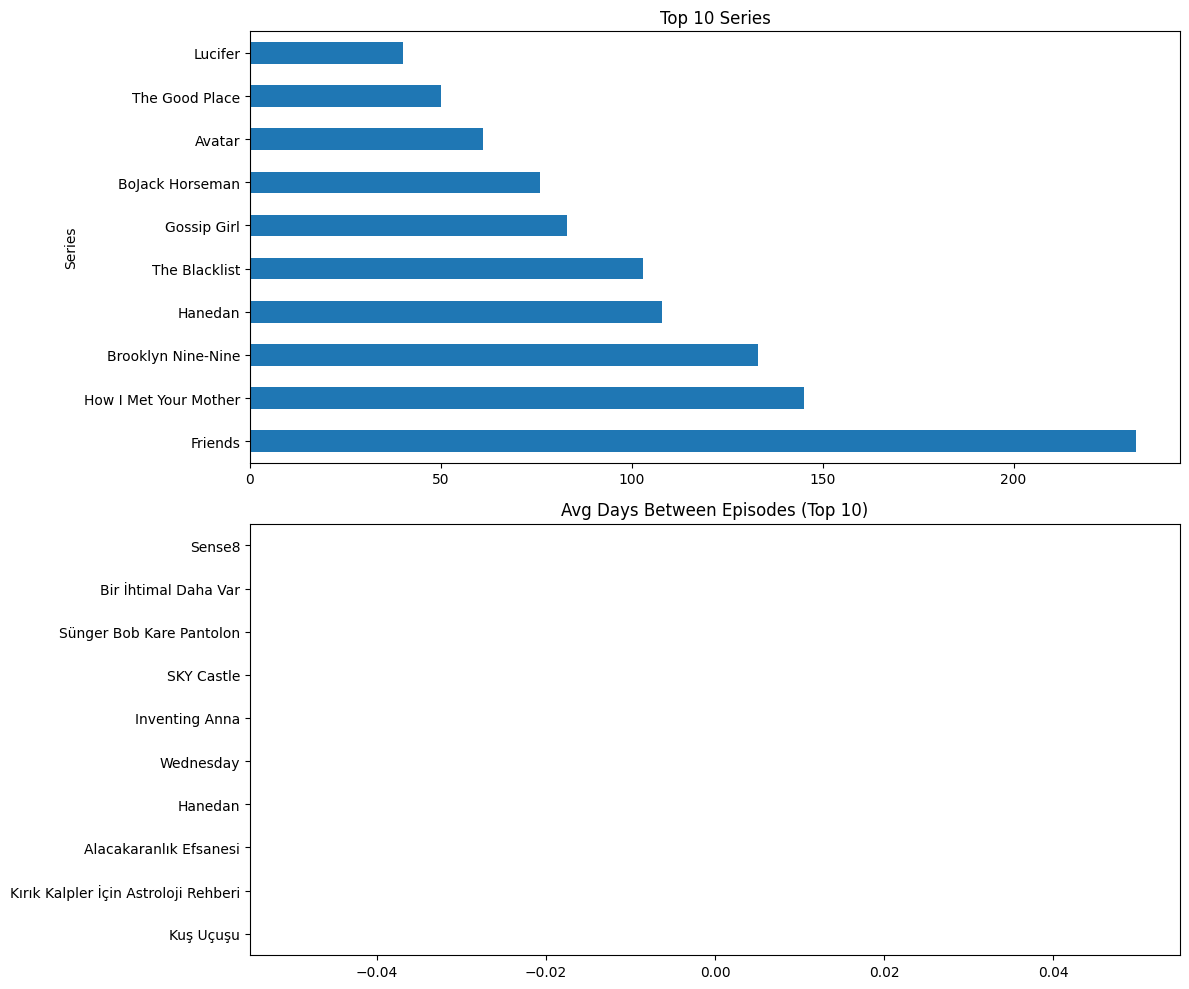

In [4]:
def analyze_series_patterns(df):
    # Filter series episodes
    df_series = df[df['Episode']!='Movie'].sort_values('Date')
    series_counts = df_series['Series'].value_counts()
    # Average gap between episodes by season
    gaps = {}
    for name, group in df_series.groupby(['Series','Season']):
        delta = group['Date'].diff().dropna().dt.days
        if not delta.empty:
            gaps[name[0]] = delta.mean()
    series_gaps = pd.Series(gaps)

    # Plot
    fig, axes = plt.subplots(2,1,figsize=(12,10))
    series_counts.head(10).plot(kind='barh', ax=axes[0], title='Top 10 Series')
    series_gaps.sort_values().head(10).plot(
        kind='barh', ax=axes[1], title='Avg Days Between Episodes (Top 10)'
    )
    plt.tight_layout()
    return series_counts, series_gaps

series_counts, series_gaps = analyze_series_patterns(df)

## 5. Movie vs Series Distribution

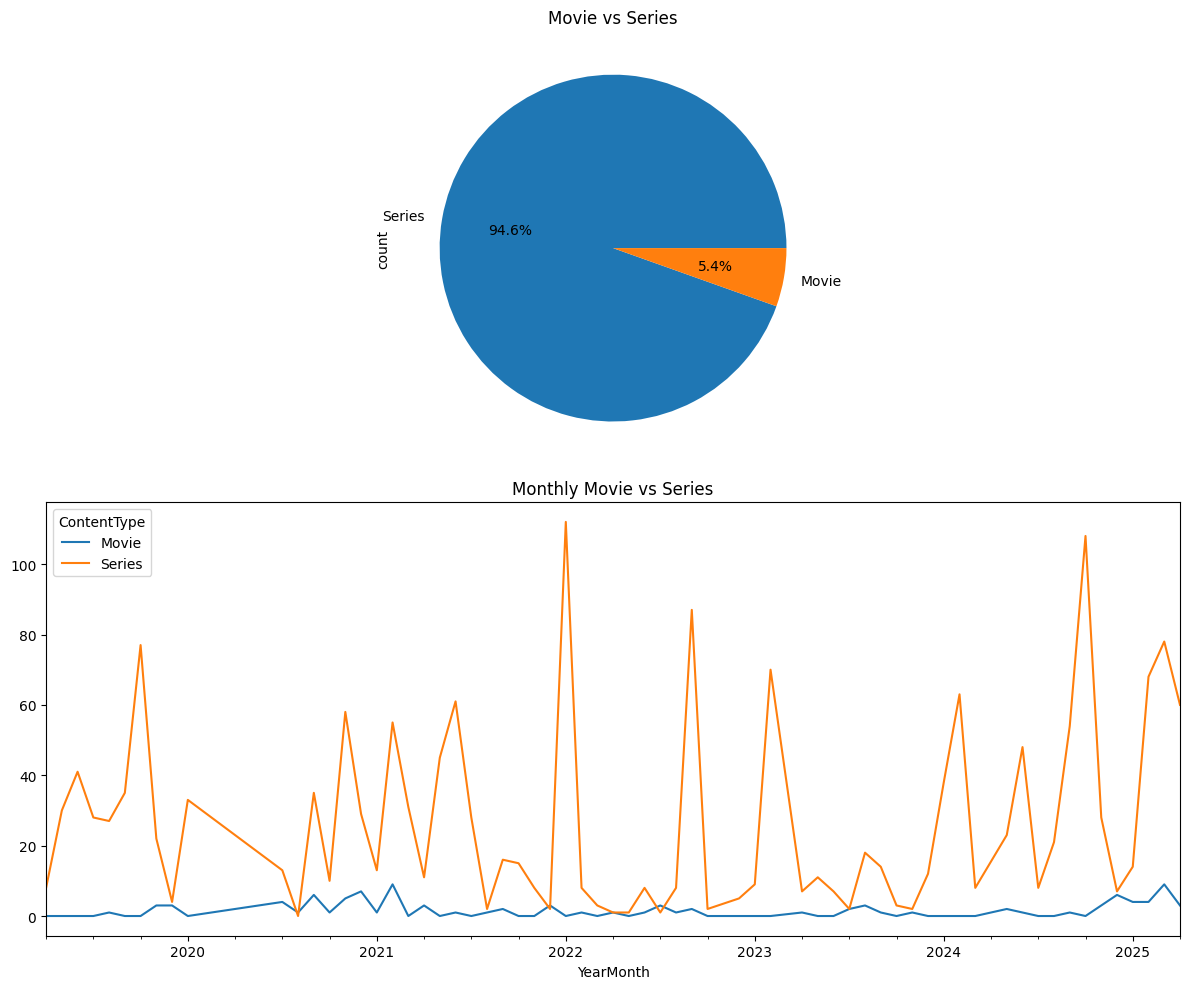

In [5]:
def analyze_content_distribution(df):
    df['ContentType'] = df['Episode'].apply(lambda x: 'Movie' if x=='Movie' else 'Series')
    content_type = df['ContentType'].value_counts()
    df['YearMonth'] = df['Date'].dt.to_period('M')
    monthly_dist = df.pivot_table(
        index='YearMonth', columns='ContentType', aggfunc='size', fill_value=0
    )

    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,10))
    content_type.plot(kind='pie', autopct='%1.1f%%', ax=ax1, title='Movie vs Series')
    monthly_dist.plot(ax=ax2, title='Monthly Movie vs Series')
    plt.tight_layout()
    return content_type, monthly_dist

content_type, monthly_dist = analyze_content_distribution(df)

## 6. Binge Watching Patterns

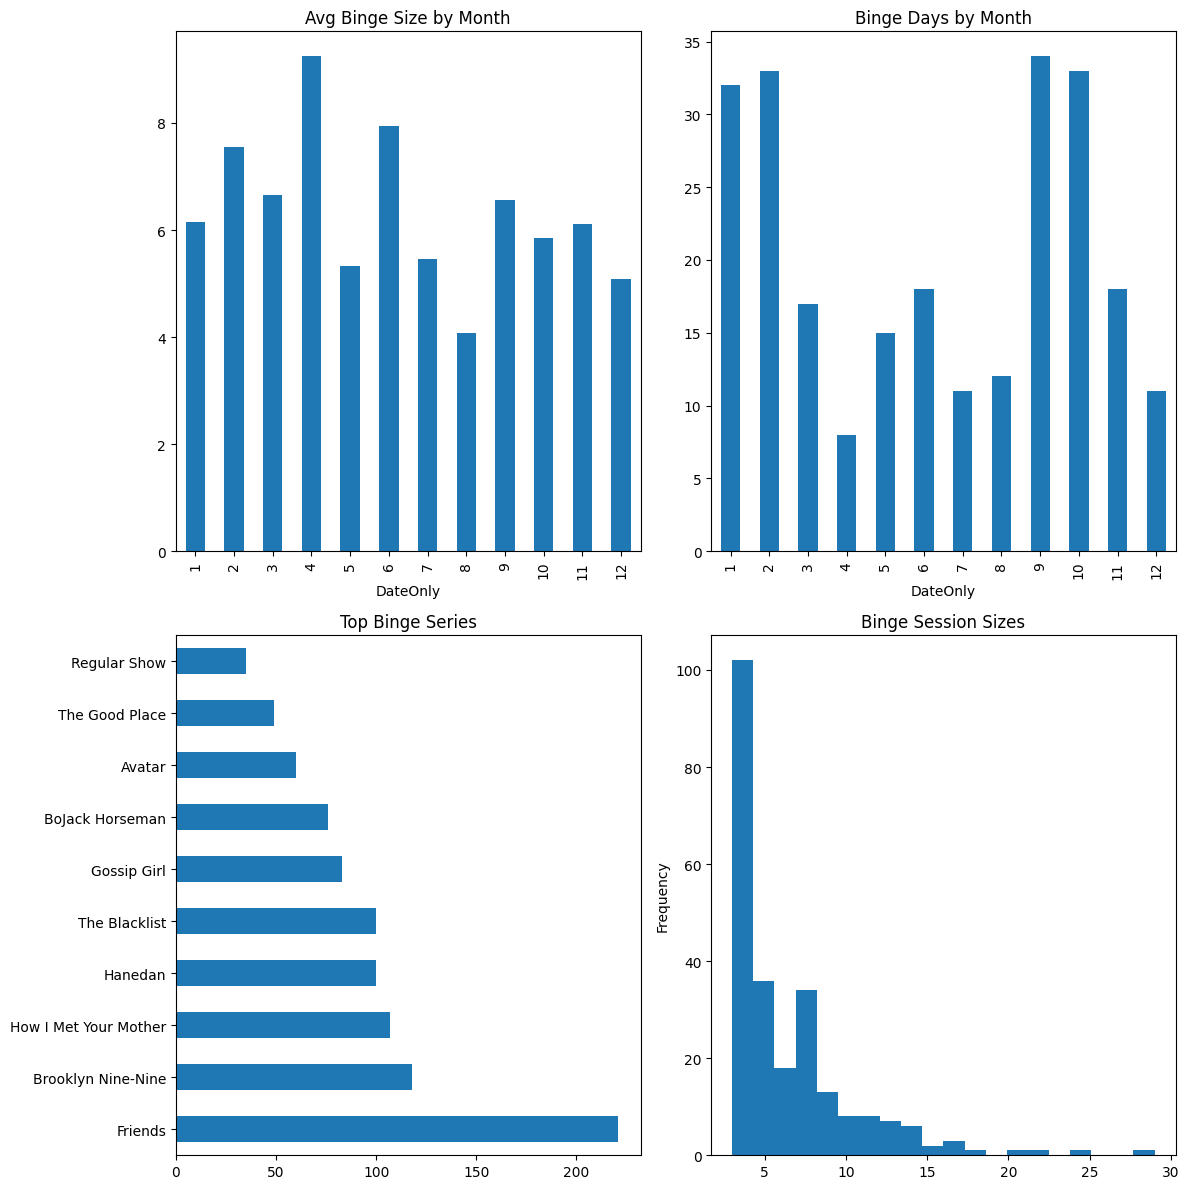

In [6]:
def analyze_binge_patterns(df):
    df['DateOnly'] = df['Date'].dt.date
    groups = df.groupby('DateOnly')
    binge_days = groups.size()[groups.size()>=3]
    binge_content = groups['Series'].apply(list)[binge_days.index]

    monthly_binges = binge_days.groupby(pd.to_datetime(binge_days.index).to_series().dt.month).agg(['mean','count'])
    top_binged = pd.Series([s for sub in binge_content for s in sub]).value_counts().head(10)

    fig, axs = plt.subplots(2,2,figsize=(12,12))
    monthly_binges['mean'].plot(kind='bar', ax=axs[0,0], title='Avg Binge Size by Month')
    monthly_binges['count'].plot(kind='bar', ax=axs[0,1], title='Binge Days by Month')
    top_binged.plot(kind='barh', ax=axs[1,0], title='Top Binge Series')
    binge_days.plot(kind='hist', bins=20, ax=axs[1,1], title='Binge Session Sizes')
    plt.tight_layout()
    return monthly_binges, top_binged

monthly_binges, top_binged = analyze_binge_patterns(df)

## 7. Seasonal Viewing Patterns

/var/folders/h4/txnzvsxj0zd2cw00_l9z1rdc0000gn/T/ipykernel_87194/487398320.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_counts = df.groupby('SeasonBin').size()
/var/folders/h4/txnzvsxj0zd2cw00_l9z1rdc0000gn/T/ipykernel_87194/487398320.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  seasonal_ct = df.pivot_table(


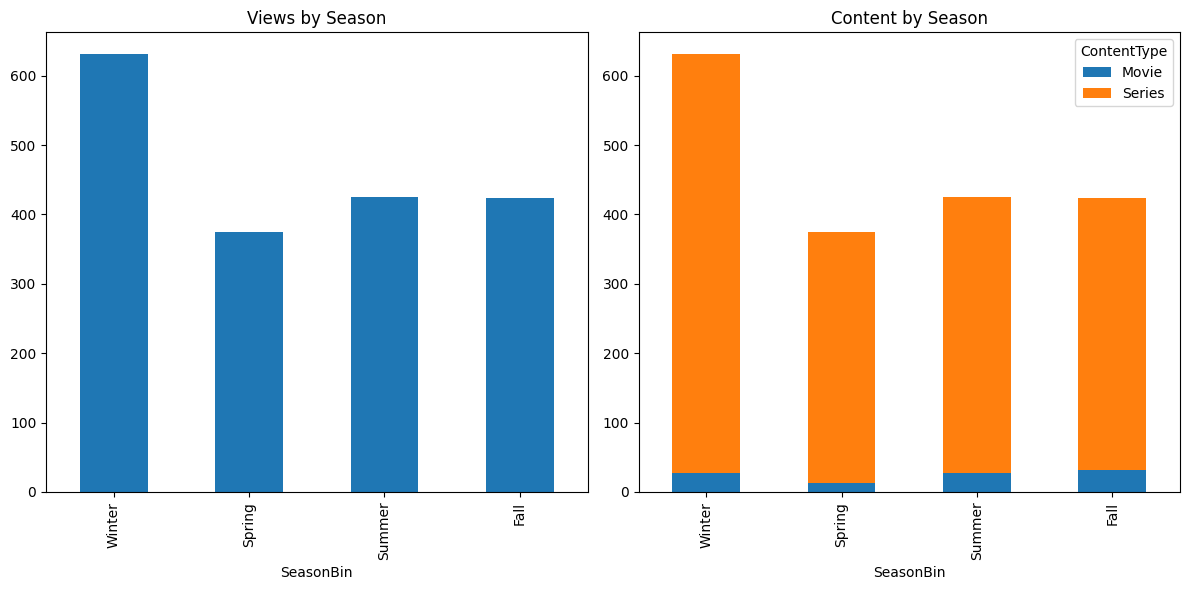

In [7]:
def analyze_seasonal_patterns(df):
    df['SeasonBin'] = pd.cut(
        df['Date'].dt.month, bins=[0,3,6,9,12],
        labels=['Winter','Spring','Summer','Fall']
    )
    seasonal_counts = df.groupby('SeasonBin').size()
    seasonal_ct = df.pivot_table(
        index='SeasonBin', columns='ContentType', aggfunc='size', fill_value=0
    )

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
    seasonal_counts.plot(kind='bar', ax=ax1, title='Views by Season')
    seasonal_ct.plot(kind='bar', stacked=True, ax=ax2, title='Content by Season')
    plt.tight_layout()
    return seasonal_counts, seasonal_ct

seasonal_counts, seasonal_ct = analyze_seasonal_patterns(df)

## 8. Advanced Correlation & Trend Analysis

Trend slope: 0.15, R²: 0.011, p-value: 0.4146


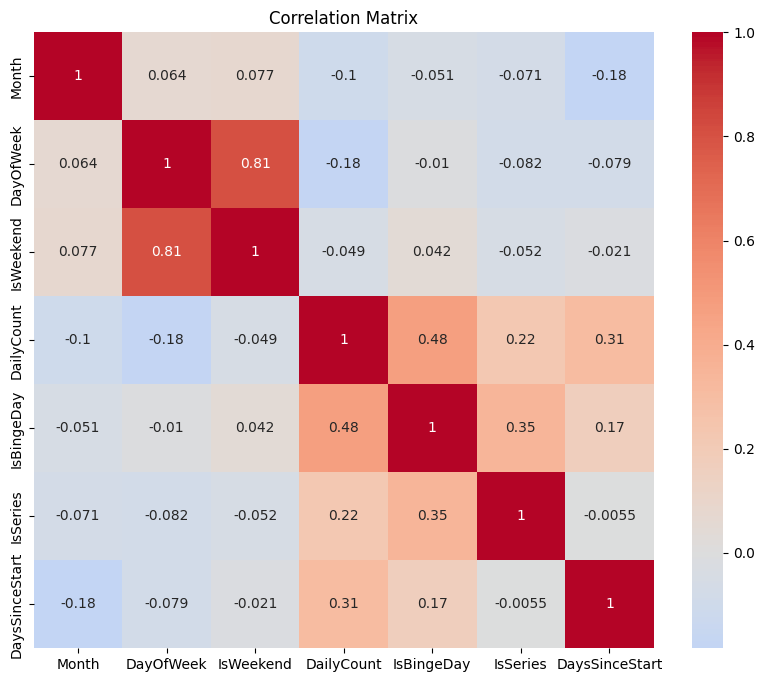

In [11]:
import seaborn as sns
from scipy import stats
import numpy as np

def advanced_viewing_analysis(df):
    df2 = df.copy()
    df2['Month'] = df2['Date'].dt.month
    df2['DayOfWeek'] = df2['Date'].dt.weekday
    df2['IsWeekend'] = df2['DayOfWeek'].isin([5,6]).astype(int)
    daily_counts = df2.groupby(df2['Date'].dt.date).size()
    df2['DailyCount'] = df2['Date'].dt.date.map(daily_counts)
    df2['IsBingeDay'] = (df2['DailyCount']>=3).astype(int)
    df2['IsSeries'] = (df2['Episode']!='Movie').astype(int)
    df2['DaysSinceStart'] = (df2['Date'] - df2['Date'].min()).dt.days

    # Correlation matrix
    corr = df2[['Month','DayOfWeek','IsWeekend','DailyCount','IsBingeDay','IsSeries','DaysSinceStart']].corr()

    # Weekly patterns
    weekend_stats = df2.groupby('IsWeekend')['DailyCount'].agg(['mean','count'])
    # Trend line on monthly counts
    monthly_counts = df2.groupby(df2['Date'].dt.to_period('M')).size()
    x = np.arange(len(monthly_counts))
    slope, intercept, r, p, _ = stats.linregress(x, monthly_counts)

    # Plot correlation heatmap
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')

    # Print trend stats
    print(f"Trend slope: {slope:.2f}, R²: {r**2:.3f}, p-value: {p:.4f}")
    return corr, weekend_stats, slope, r, p

corr, weekend_stats, slope, r, p = advanced_viewing_analysis(df)